# Lab Assignment Eight: Exploring Image Data -- CNN

$$ Members: Rongxiao Huang,   Zee Liu,   Hua Zong $$

<a id="top"></a>
## Contents
* <a href="#BD">1. Business Understanding & Data Preparation</a>
* <a href="#MO">2. Modeling</a>
* <a href="#VS">3. Visualize the Convolutional Filters  </a>
* <a href="#RE">Reference</a>

___
<a id="BD"></a>
<a href="#top">Back to Top</a>
## 1. Business Understanding and Data Preparation

### 1.1 Business Understanding

`CIFAR-10` is an established computer-vision dataset used for object recognition. Its train set is a subset of the 80 million tiny images dataset and consists of **50,000 32x32 color images containing one of 10 object classes, with 5,000 images per class**. And its test set consists of **10,000 32x32 color images with 1,000 images per class**. It was collected by `Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton`.
- https://www.kaggle.com/c/cifar-10
 
We aim to classify the images and attach a label to each image. We created **contingency tables** for the test set counting the number of instances correctly classified in each class and we also calculated the corresponding accuracy scores.

There is a giant number of images on line. They need to be grouped together according to their target classes and attached labels in order to do **information management**. This data is for the learning purpose by comparing different methods, MLP and CNN in our project, in dealing with low quality images (small number of pixels).

### 1.2 Data Preparation

The class variable is the target label: 'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'.

The features are the 32*32 = 1024 pixels since the image sizes are 32 pixels by 32 pixels. But in this section, we did not perform one-dimension transformation because we could directly create some model from original dimension of data. Here we visualized some images from the 10 classes in both RGB scale and grey scale.

The train set: 50,000 images, 32*32*3 per image.
The test set: 10,000 images, 32*32*3 per image.

In [1]:
import keras
from keras.datasets import cifar10
from scipy.misc import imresize

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(y_train.shape)

Using TensorFlow backend.


(50000, 32, 32, 3)
(50000, 1)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

labels = ['airplane','automobile','bird','cat',
                        'deer','dog','frog','horse','ship','truck']

label_train = y_train[:,0]
label_test = y_test[:,0]

label_train = pd.Series(label_train, dtype="category")
label_test = pd.Series(label_test, dtype="category")

label_train = label_train.cat.rename_categories(labels)
label_test = label_test.cat.rename_categories(labels)

label_train = np.array(label_train)
label_test = np.array(label_test)

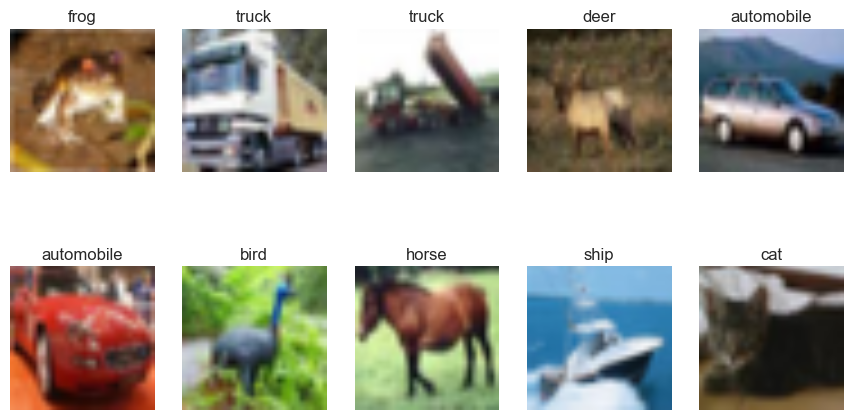

In [5]:
# visualize several images
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# a helper plotting function
def plot_gallery(images, titles, n_row=2, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(x_train, label_train)

In [10]:
# recolor images since color should not make much sense in feature extraction
# create a function to define the color mixture for gray
def weightedAverage(pixel):
    return (0.299*pixel[0] + 0.587*pixel[1] + 0.114*pixel[2])/255

# convert to grayscale
train_grey = []
test_grey = []

for image in x_train:
    grey = np.zeros((image.shape[0], image.shape[1]))
    for rownum in range(image.shape[0]):
        for colnum in range(image.shape[1]):
            grey[rownum][colnum] = weightedAverage(image[rownum][colnum])
    train_grey.append(grey)

for image in x_test:
    grey = np.zeros((image.shape[0], image.shape[1]))
    for rownum in range(image.shape[0]):
        for colnum in range(image.shape[1]):
            grey[rownum][colnum] = weightedAverage(image[rownum][colnum])
    test_grey.append(grey)


In [11]:
train_grey = np.array(train_grey)
test_grey = np.array(test_grey)

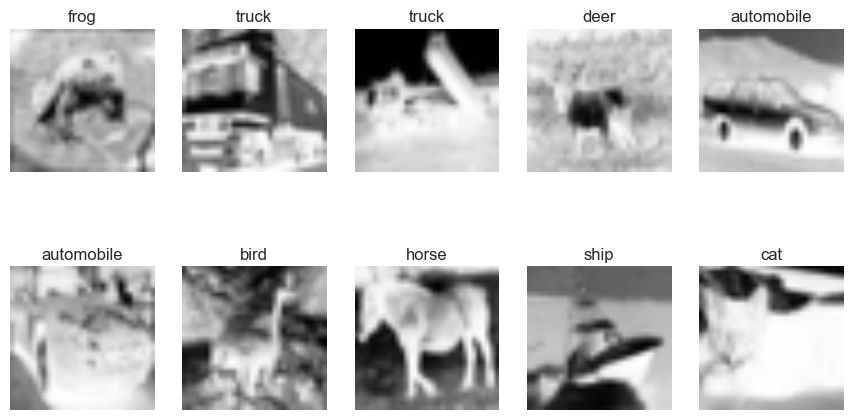

In [12]:
plot_gallery(train_grey, label_train)

### 1.3. Evaluation Metrics

Because the test set consists of 10,000 images, and 1,000 images for each classes, the data set is balanced. Therefore, it is approapriate to use accuracy as our evaluation metric. (For unbalanced data, we would like to use f1 score.)

In [6]:
train_list = list(y_train)

for i in labels:
    print ("Count for " + i + " : ", train_list.count(y_train == i))

Count for airplane :  5000
Count for automobile :  5000
Count for bird :  5000
Count for cat :  5000
Count for deer :  5000
Count for dog :  5000
Count for frog :  5000
Count for horse :  5000
Count for ship :  5000
Count for truck :  5000


In [7]:
test_list = list(y_test)

for i in labels:
    print ("Count for " + i + " : ", test_list.count(y_train == i))

Count for airplane :  1000
Count for automobile :  1000
Count for bird :  1000
Count for cat :  1000
Count for deer :  1000
Count for dog :  1000
Count for frog :  1000
Count for horse :  1000
Count for ship :  1000
Count for truck :  1000


### 1.4. Shuffle split

We performed two times of stratified sampling (after shuffling) to generate 80% of the train data to do modeling and the rest 20% used for testing. Due to the computaion burden, here we just did two splits, while usually it would be better to do more splits to obtain a general performance. In addition, we have our original 10000-image test set, which was also used for evaluation purpose.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
sp_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sp_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

___
<a id="MO"></a>
<a href="#top">Back to Top</a>
## 2. Modeling

### 2.1 MLP versus CNN in Grey Scale

In this section, we first conveted the colored images to grey scales. And then created a standard MLP as well as simple CNN. At the end of the section, we compared two models by evaluating the contingency tables and accuracy scores.

### MLP in Grey Scale

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.0.3'

In [14]:
NUM_CLASSES = 10

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(train_grey.shape)
print(test_grey.shape)

(50000, 32, 32)
(10000, 32, 32)


In [60]:
train_grey = train_grey.reshape((50000, 1024))
test_grey = test_grey.reshape((10000, 1024))

for train_index, test_index in sp_1.split(train_grey, y_train):
    sp1x_train, sp1x_test = train_grey[train_index], train_grey[test_index]
    sp1y_train, sp1y_test = y_train_ohe[train_index], y_train_ohe[test_index]
    sp1_y_train, sp1_y_test = y_train[train_index], y_train[test_index]
    
for train_index, test_index in sp_2.split(train_grey, y_train):
    sp2x_train, sp2x_test = train_grey[train_index], train_grey[test_index]
    sp2y_train, sp2y_test = y_train_ohe[train_index], y_train_ohe[test_index]
    sp2_y_train, sp2_y_test = y_train[train_index], y_train[test_index]

In [20]:
%%time

# make a 3 layer keras Mlp
mlp1 = Sequential()
mlp1.add( Dense(input_dim=train_grey.shape[1], units=30, activation='relu') )
mlp1.add( Dense(units=15, activation='relu') )
mlp1.add( Dense(NUM_CLASSES) )
mlp1.add( Activation('softmax') )

mlp1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp1.fit(sp1x_train, sp1y_train, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

mlp1_proba = mlp1.predict_proba(test_grey)

 9504/10000 [===========================>..] - ETA: 0sWall time: 10min 49s


### CNN in Grey Scale

In [19]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn1 = Sequential()

cnn1.add(Reshape((1,32,32), input_shape=(1,1024)))
num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add(Conv2D(filters=num_filters, 
                    kernel_size=(4,4), 
                    padding='same'))
    cnn1.add(Activation('relu'))
    cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn1.add(Flatten())
cnn1.add(Dense(100))
cnn1.add(Activation('relu'))
cnn1.add(Dense(NUM_CLASSES))
cnn1.add(Activation('softmax'))

# Let's train the model 
cnn1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(np.expand_dims(sp1x_train, axis=1), sp1y_train, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

cnn1_proba = cnn1.predict_proba(np.expand_dims(test_grey, axis=1))

 9024/10000 [==========================>...] - ETA: 0sWall time: 15min 27s


In [21]:
%%time

# make a 3 layer keras Mlp
mlp2 = Sequential()
mlp2.add( Dense(input_dim=train_grey.shape[1], units=30, activation='relu') )
mlp2.add( Dense(units=15, activation='relu') )
mlp2.add( Dense(NUM_CLASSES) )
mlp2.add( Activation('softmax') )

mlp2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp2.fit(sp2x_train, sp2y_train, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

mlp2_proba = mlp2.predict_proba(test_grey)

 9152/10000 [==========================>...] - ETA: 0sWall time: 11min 19s


In [22]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn2 = Sequential()

cnn2.add(Reshape((1,32,32), input_shape=(1,1024)))
num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn2.add(Conv2D(filters=num_filters, 
                    kernel_size=(4,4), 
                    padding='same'))
    cnn2.add(Activation('relu'))
    cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(100))
cnn2.add(Activation('relu'))
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(sp2x_train, axis=1), sp2y_train, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

cnn2_proba = cnn2.predict_proba(np.expand_dims(test_grey, axis=1))

 9696/10000 [============================>.] - ETA: 0sWall time: 15min 33s


In [23]:
%%time

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=train_grey.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(train_grey, y_train_ohe, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

mlp_proba = mlp.predict_proba(test_grey)

 9472/10000 [===========================>..] - ETA: 0sWall time: 14min 51s


In [63]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn = Sequential()

cnn.add(Reshape((1,32,32), input_shape=(1,1024)))
num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn.add(Conv2D(filters=num_filters, 
                    kernel_size=(4,4), 
                    padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(100))
cnn.add(Activation('relu'))
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(train_grey, axis=1), y_train_ohe, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

cnn_proba = cnn.predict_proba(np.expand_dims(test_grey, axis=1))

 9312/10000 [==========================>...] - ETA: 0sWall time: 21min 17s


In [53]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_cnn_mlp(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title("CNN : " + str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title("MLP : " + str(acc_mlp))

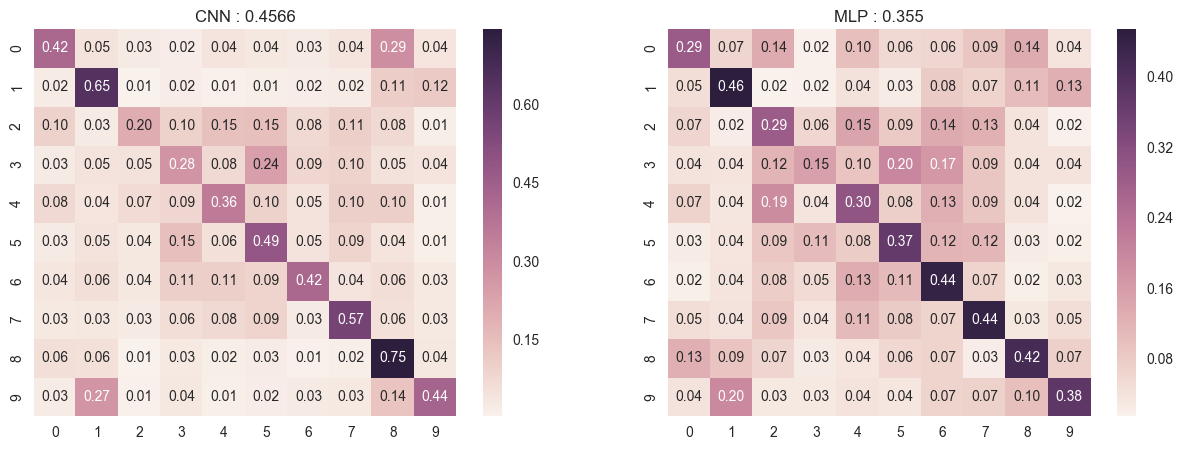

In [61]:
# compare first training results
compare_cnn_mlp(cnn1,mlp1,sp1x_test,sp1_y_test)

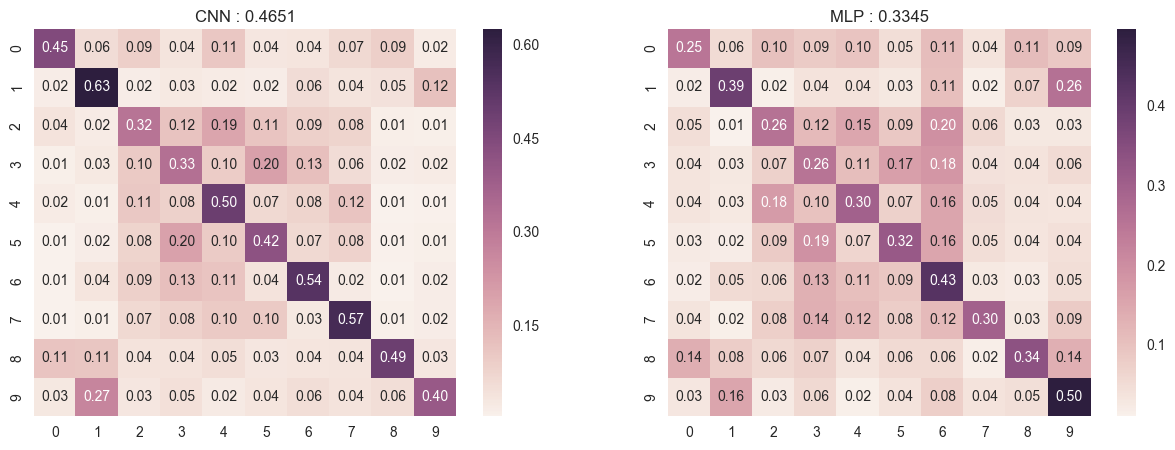

In [62]:
# compare second training results
compare_cnn_mlp(cnn2,mlp2,sp2x_test,sp2_y_test)

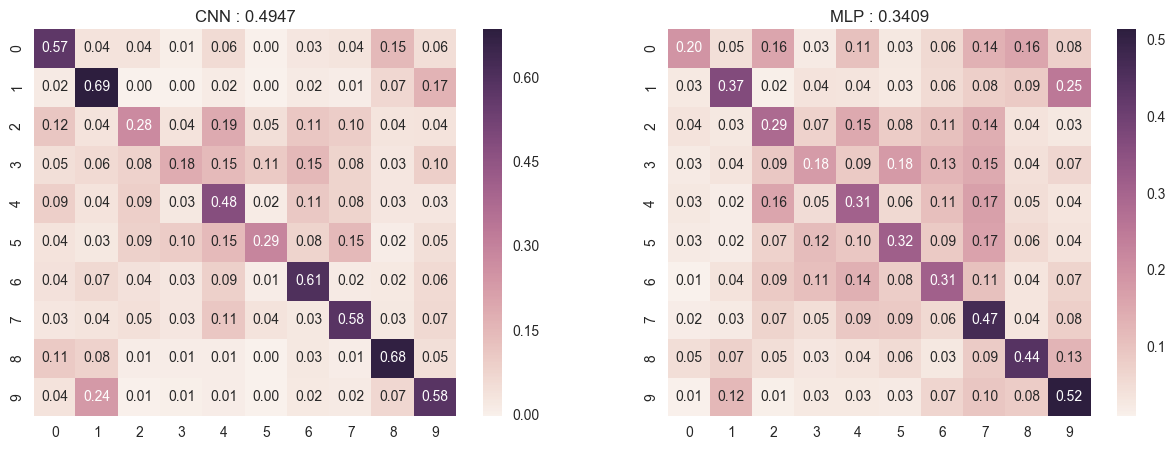

In [64]:
# compare overall training results
compare_cnn_mlp(cnn,mlp,test_grey,y_test)

From the plots above, we found that CNN has a better accuracy compared to MLP, and has larger numbers in the diagnal lines in the contingency tables while smaller numbers off the diagnal lines. Besides, CNN has the better performace with larger amount of training data.

### 2.2. CNN in RGB Scale

In this section, we used the RGB images directly to train CNN. And then we continued to create another CNN by implementing the idea of ensemble. At the end of the section, we plots the contigency tables and calculate the accuracy scores for both.

In [65]:
# what if we just want to use the validation data??
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn_adv = Sequential()

cnn_adv.add(Conv2D(24, (4,4), padding='same',
               input_shape=x_train.shape[1:],
               data_format="channels_last", 
               kernel_regularizer=l2(l2_lambda), 
               activation='relu')) # more compact syntax
cnn_adv.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
cnn_adv.add(BatchNormalization())
cnn_adv.add(Dropout(0.25))


cnn_adv.add(Conv2D(24, (4,4),
               kernel_regularizer=l2(l2_lambda),
               data_format="channels_last", 
               padding='same', 
               activation='relu'))
cnn_adv.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
cnn_adv.add(BatchNormalization())
cnn_adv.add(Dropout(0.25))    

# add one layer on flattened output
cnn_adv.add(Flatten())
cnn_adv.add(Dense(100, 
              activation='relu',
              kernel_regularizer=l2(l2_lambda)))
cnn_adv.add(Dropout(0.25))

# add some dropout for regularization, again!
cnn_adv.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_regularizer=l2(l2_lambda) ))

# Let's train the model 
cnn_adv.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

cnn_adv.fit(x_train, y_train_ohe, 
            epochs=50, verbose=0,
            validation_data=(x_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
            )

cnn_adv_proba = cnn_adv.predict_proba(x_test)

 9888/10000 [============================>.] - ETA: 0s

### Ensemble RGB

In [67]:
%%time

from keras.layers import average 
from keras.models import Input, Model

input_holder = Input(shape=(32,32,3))

num_ensembles = 3

branches = []
for _ in range(num_ensembles):

    conv1 = Conv2D(filters=24,
                   input_shape = (32,32,3),
                   kernel_size=(4,4), 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu')(input_holder)
    
    max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

    conv2 = Conv2D(filters=24,
                   kernel_size=(4,4),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu')(max1)
    
    max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


    # add one layer on flattened output
    drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
    flat1 = Flatten()(drop1)
    dense1 = Dense(100, 
                  activation='relu',
                  kernel_regularizer=l2(l2_lambda)
                )(flat1)
    drop2 = Dropout(0.25)(dense1) # add some dropout for regularization, again!
    dense2 = Dense(NUM_CLASSES, 
                  activation='softmax', 
                  kernel_regularizer=l2(l2_lambda)
                 )(drop2)
    
    # now add this branch onto the master list
    branches.append(dense2)
    
# that's it, we just need to average the results
ave = average(branches)

# here is the secret sauce for setting the network using the 
#   Model API:
cnn_ens = Model(inputs=input_holder,outputs=ave)

# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit(x_train, y_train_ohe, 
            epochs=50, verbose=0,
            validation_data=(x_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
            )

Wall time: 7min 39s


In [69]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_cnn(cnn1, cnn2, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn1 is not None:
        yhat_cnn = np.argmax(cnn1.predict(X_test),axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title("RGB_CNN : " + str(acc_cnn))
    
    if cnn2 is not None:
        yhat_mlp = np.argmax(cnn2.predict(X_test),axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title("RGB_ENSEMBLE: " + str(acc_mlp))

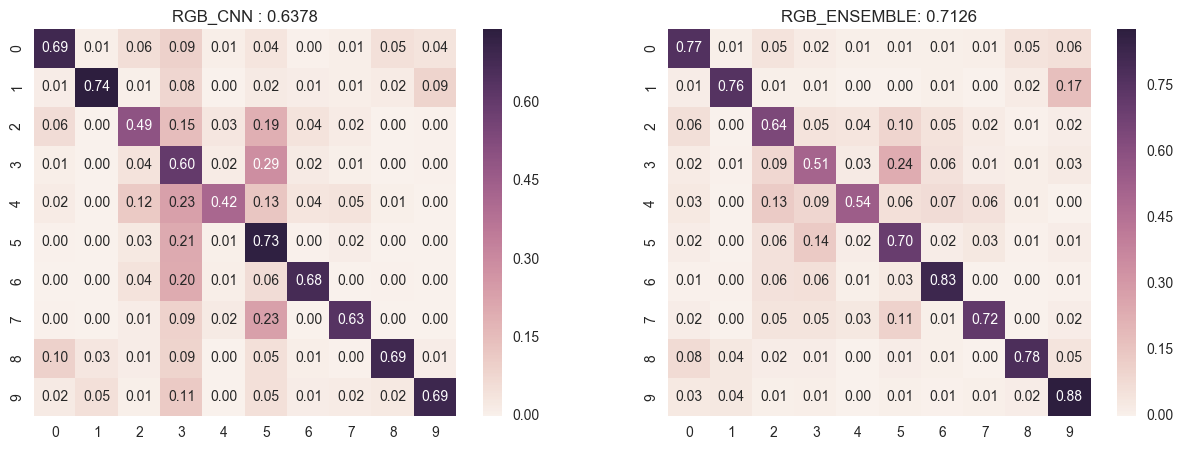

In [70]:
compare_cnn(cnn_adv,cnn_ens,x_test,y_test)

The results are much more better than the CNN created by using images in grey scale: the accuracy score -- 0.49 vs 0.64 or even 0.71 in the ensemble version. But you may find that the accuracy improved thanks to the implemetation of techniques of 'drop out', 'batch normalization', and 'ensemble'.

### 2.3. ROC curve

We created ROC curves for MLP, CNN in grey scale and CNN in RGB.

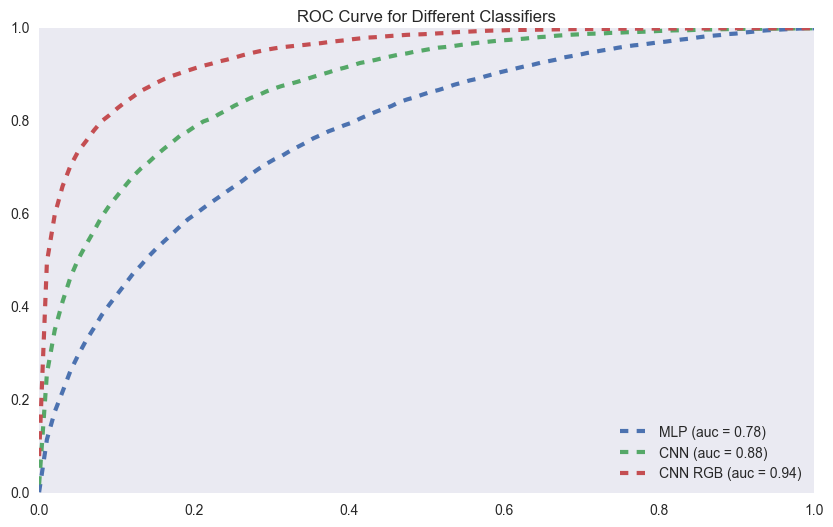

In [71]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

classes = np.unique(y_test)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


proba = [mlp_proba, cnn_proba, cnn_adv_proba,]
labels = ['MLP', 'CNN', 'CNN RGB']
plt.figure(figsize=(10,6))

for j in range(len(proba)):
    proba_ = proba[j]
    
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for i in classes:
        fpr, tpr, thresholds = roc_curve(y_test,
                                proba_[:, i],
                                pos_label=i)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        #perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=3,label='%s (auc = %0.2f)' % (labels[j], roc_auc))

plt.legend(loc='best')
plt.title('ROC Curve for Different Classifiers')
plt.grid()

The graph above shows that CNN out competes the other two models overall. 

___
<a id="VS"></a>
<a href="#top">Back to Top</a>
## 3. Visualize the Convolutional Filters 

In [72]:
model_RGB = Sequential()

model_RGB.add(Conv2D(24, (4,4), 
                     input_shape=x_train.shape[1:],
                     padding='same',
                  data_format="channels_last"))


cnn2_f = model_RGB.predict(x_train)

To visualize the RGB filters chosen by our RGB CNN, we need to the array predicted from the model before it enters the regular MLP. And we also decided to use the filters before it applying the activation function into it. And with the array predicted from the model, we will be able to convert numbers into filtered images again.

And the cnn2_f has an array shape of (50000, 32, 32, 24). As we use the RGB file type to train the model (with shape of 50000, 32, 32). It implies that the R layer, G layer, and B layer are filtered 8 times respectively as the number output of filters in the convolution is 24. In the other word, we are able to generate 8 filtered images through our previous setting.

In [73]:
# create a funtion to get RGB layers respectively for one specific image
def img_filter(img_data, img_num):
    pic = img_data[img_num]
    fil = []
    for i in range(8):
        aa = pic[:,:,[i,i+8,i+16]]
        fil.append(aa)
        img_fil=np.array(fil)
        
    return img_fil

From the above funtion, we can choose an image number and get the 24 filtered layers from the predicted array. At very first, we were curious about how the CNN filtered the layers, either in "RGB, RGB, RGB..." order, or in "RRR...GGG...BBB" order. After first try with "RGB, RGB, RGB...", we got an weird filtered image. And this didn't make any sense. Therefore, we conclude that it's filtered in "RRR...GGG...BBB" order. And the above function could re-arrange the array of one specific image to be an image-producible one.

In [75]:
img_num = 0
pic1 = img_filter(cnn2_f, img_num)

# create a gallery function to diplay the filters
def filter_gallery(images, n_row=2, n_col=4):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(label_train[img_num], size=12)
        plt.xticks(())
        plt.yticks(())

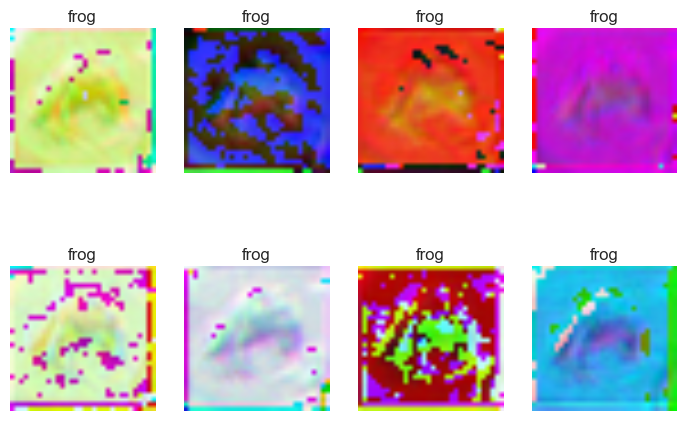

In [76]:
filter_gallery(pic1)

The first iamge in the dataset with filters are displayed as above. And we also randomly seleted other two images to show the filters. 

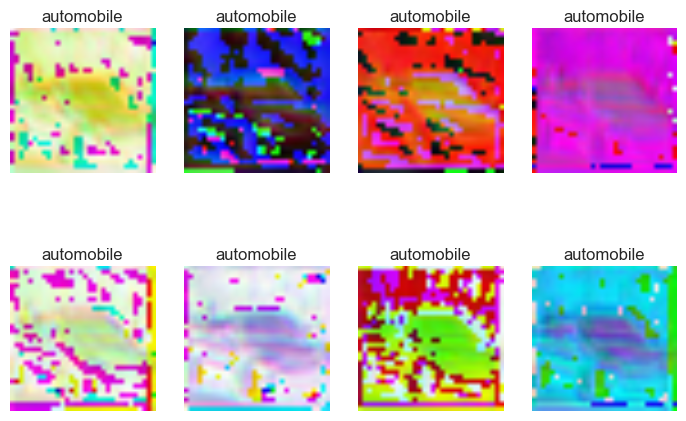

In [77]:
img_num = 354
pic2 = img_filter(cnn2_f, img_num)
filter_gallery(pic2)

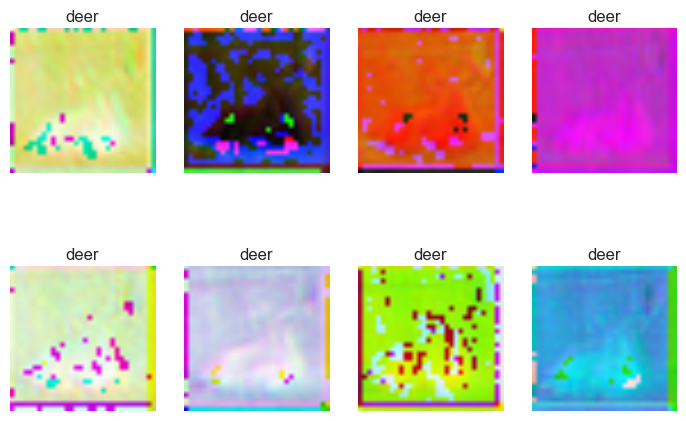

In [78]:
img_num = 26512
pic3 = img_filter(cnn2_f, img_num)
filter_gallery(pic3)

From all these filters visualized above, we are able to observe a basic shape of the object in the original image. Especially in the automobile set, it is very visual clearly to see a car shape. And in the deer set, we can still able to observe some clear shapes in some images. But some filters in the deer set are not that clear compared to the automatic set. It may be because the deer image is usually in the natural environment and it might to have a sharp edges with the image backgroud. And automoblie could have the sharper edge with the image backgroud. But we are very glad to see these clear shapes even with the one convolutional layer in the network. 

But maybe this image dataset, it's the very low pixel size image dataset. One convolutional layer could work well. And for the larger pixel size, we may need to use more convolutional layers in the model.

____
<a id="RE"></a>
<a href="#top">Back to Top</a>
##  Reference

Kaggle. CIFAR-10 - Object Recognition in Images.
    https://www.kaggle.com/c/cifar-10  (Accessed 02/14/2017)